# Contrastive Language–Image Pre-training Embeddings

[Example Source Code](https://colab.research.google.com/drive/1T3gfEF7pkXgPPajNa9ZjurB25B0RJ3_X?usp=sharing)

In [29]:
from pathlib import Path
data_dir = Path('./data').resolve()
if not output_dir.exists():
    data_dir.mkdir()


In [44]:
import cv2
import os

def sample_indices(end, count):
    return [i*(end//(count)) for i in range(count)]

def extract_frames(video_path, output_folder, samples=10):
    # Create the output directory if it doesn't exist
    output_folder = Path(output_folder)
    if not output_folder.exists():
        output_folder.mkdir()
    output_img_folder = output_folder / "images"
    if not output_img_folder.exists():
        output_img_folder.mkdir()

    
    # Capture the video from the file
    video_capture = cv2.VideoCapture(video_path)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    indices = sample_indices(total_frames, samples)
    
    # Check if video opened successfully
    if not video_capture.isOpened():
        print("Error opening video file")
        return

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        if saved_count >= samples:
            break
        if frame_count ==  indices[saved_count]:
            frame_filename = os.path.join(output_img_folder.as_posix(), f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_count += 1

        frame_count += 1

    video_capture.release()
    print(f"Extracted {saved_count} frames of total {total_frames} frames from the video {Path(video_path).name}")

def get_images_paths(directory, extension):
    directory = Path(directory)
    return list(directory.glob(f'*{extension}'))

In [41]:
SAMPLES = 10

video_names = ['elden_ring-tree_sentinel', 'elden_ring-fortheglen', 'red_redemption-webber_beast', 'red_redemption-seeker']

for video_name in video_names:
    video_folder = data_dir / video_name
    video_path = (video_folder / f"{video_name}.mp4").as_posix()
    extract_frames(video_path, video_folder, SAMPLES)

Extracted 10 frames of total 2737 frames from the video elden_ring-tree_sentinel.mp4
Extracted 10 frames of total 3591 frames from the video elden_ring-fortheglen.mp4
Extracted 10 frames of total 3650 frames from the video red_redemption-webber_beast.mp4
Extracted 10 frames of total 3287 frames from the video red_redemption-seeker.mp4


In [57]:
all_imgs_paths = []
for video_name in video_names:
    imgs_folder = data_dir / video_name / 'images'  
    img_paths = get_images_paths(imgs_folder.as_posix(), '.jpg')
    all_imgs_paths.extend(img_paths)
print(len(all_imgs_paths))

40


In [52]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')

/Users/dz/Library/Python/3.9/lib/python/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/dz/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/dz/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [58]:
from PIL import Image

img_emb = model.encode([Image.open(filepath) for filepath in all_imgs_paths], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

Batches: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


In [64]:
# We have implemented our own, efficient method
# to find high density regions in vector space
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=40):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [65]:
clusters = community_detection(img_emb, threshold=0.9, min_community_size=5)
print("Total number of clusters:", len(clusters))

Total number of clusters: 3




Cluster size: 10


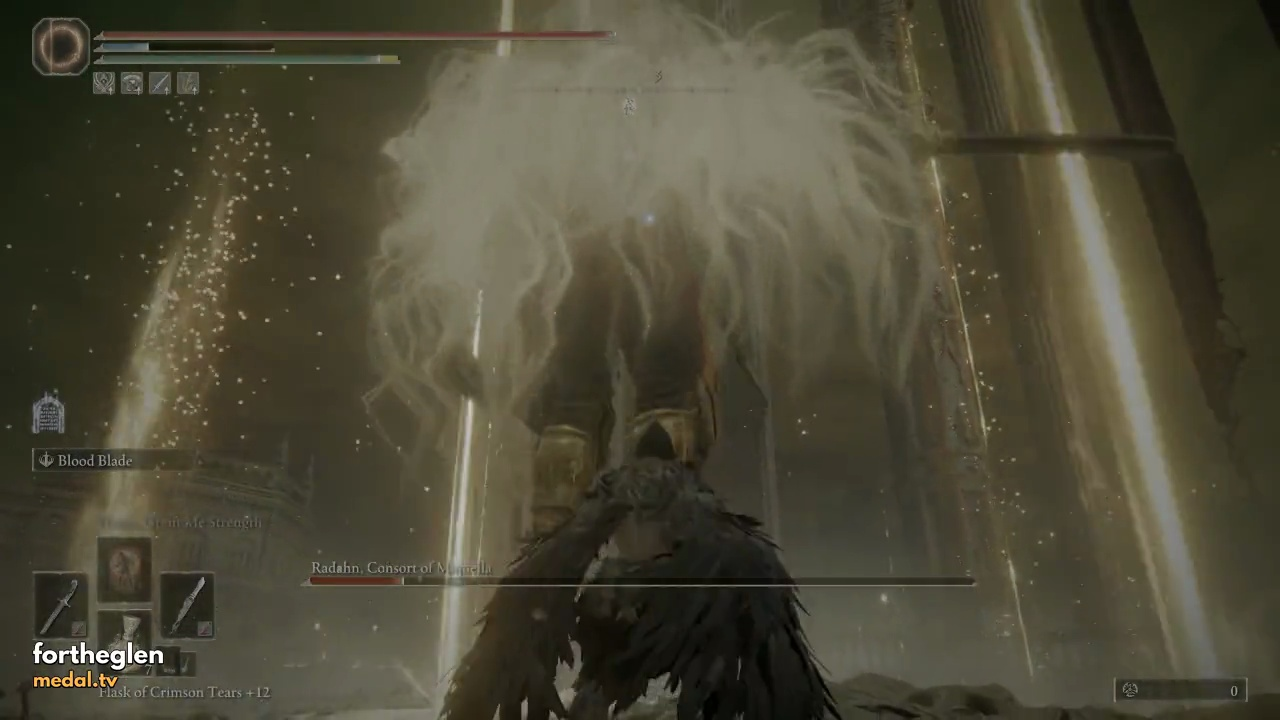

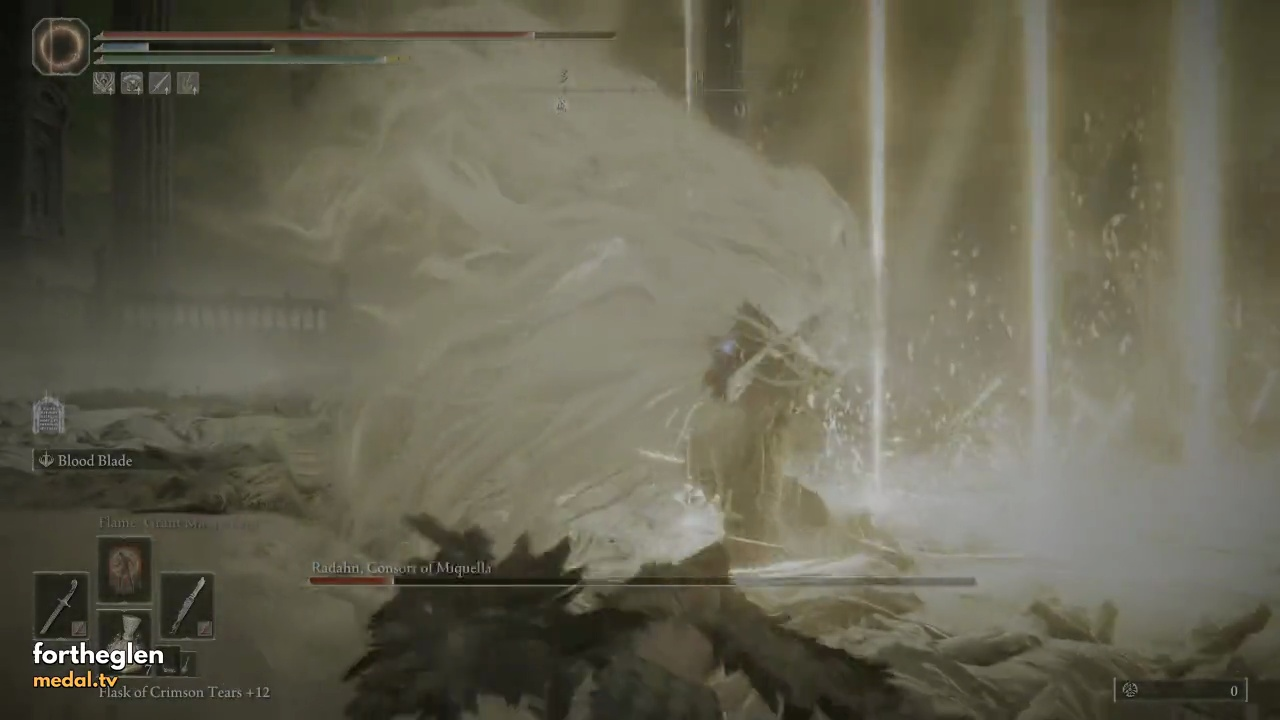

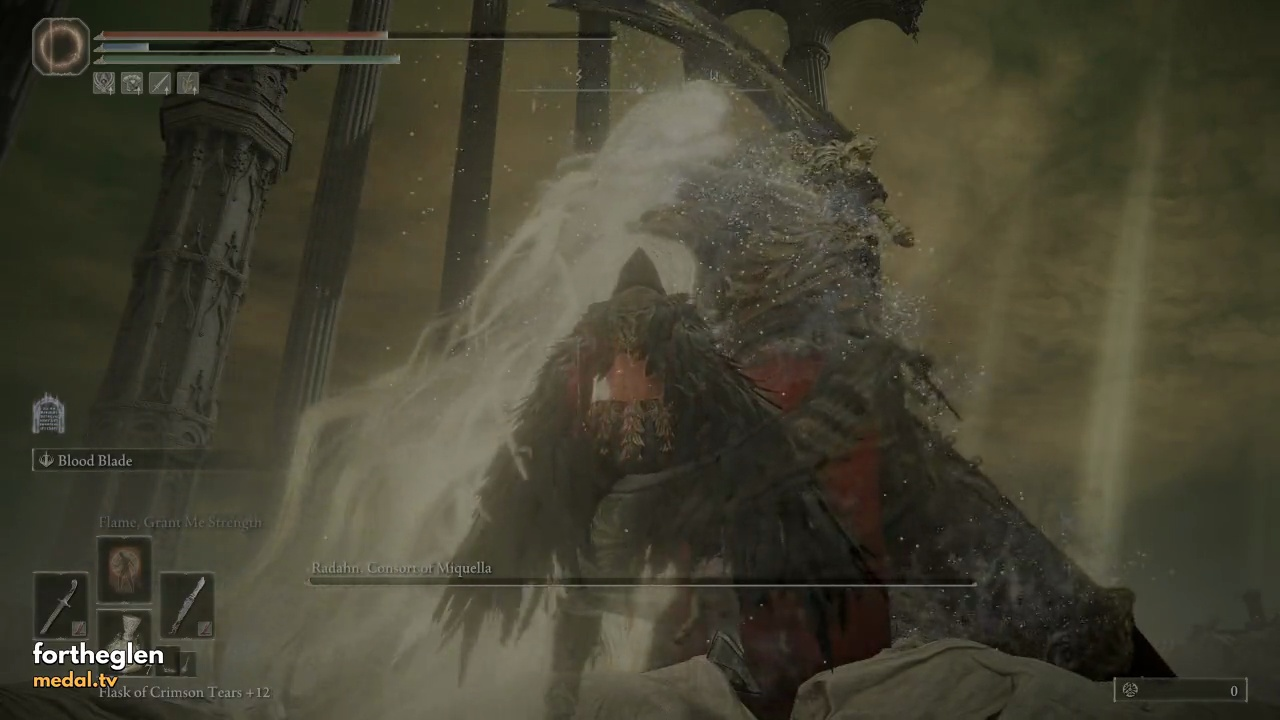

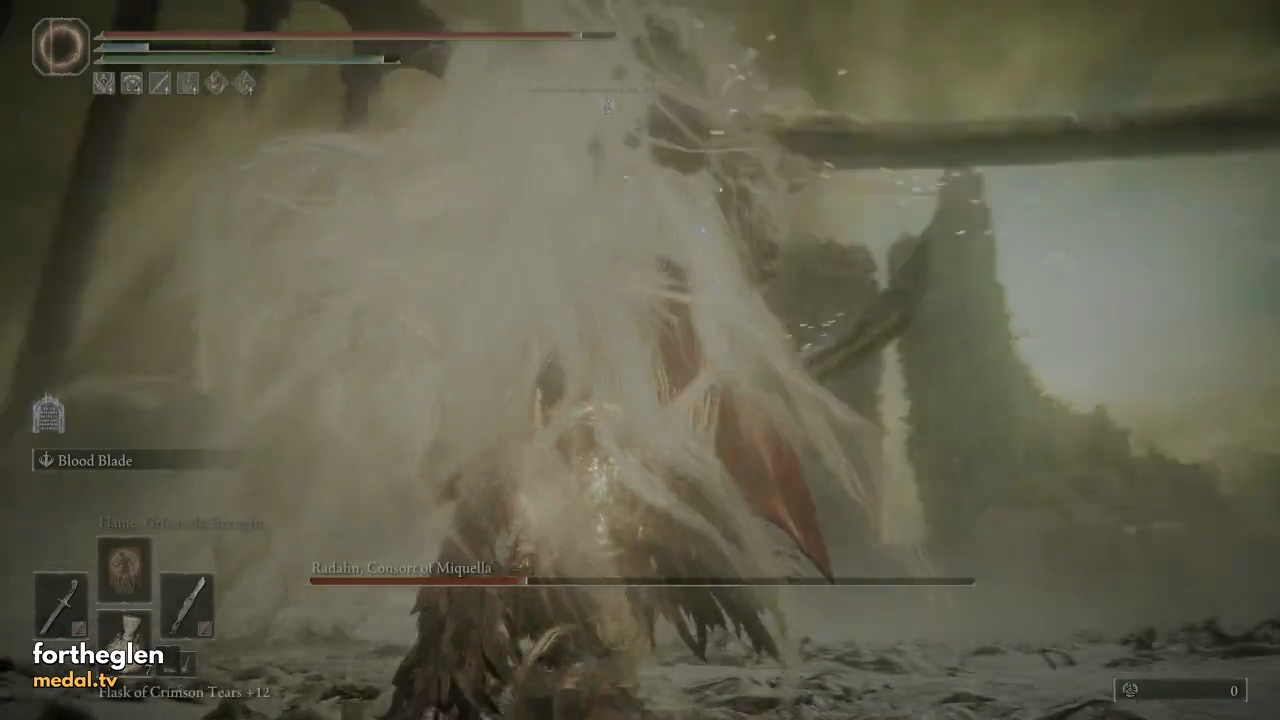

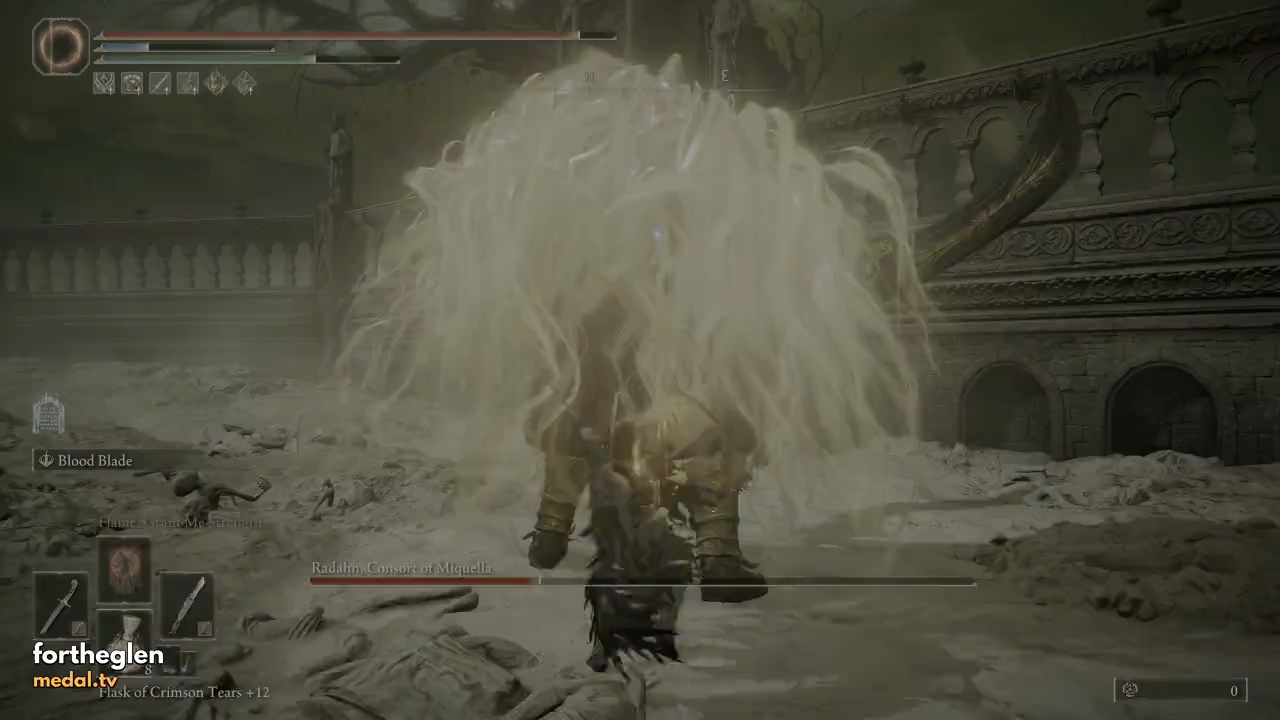

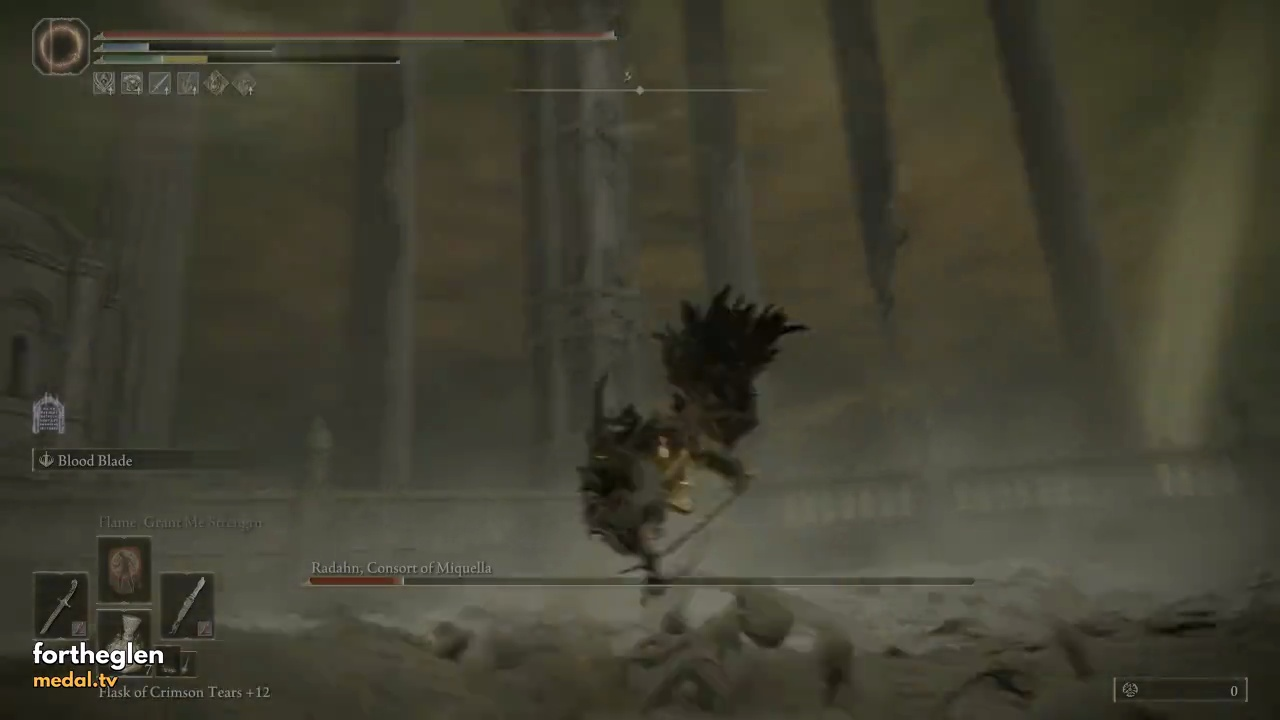

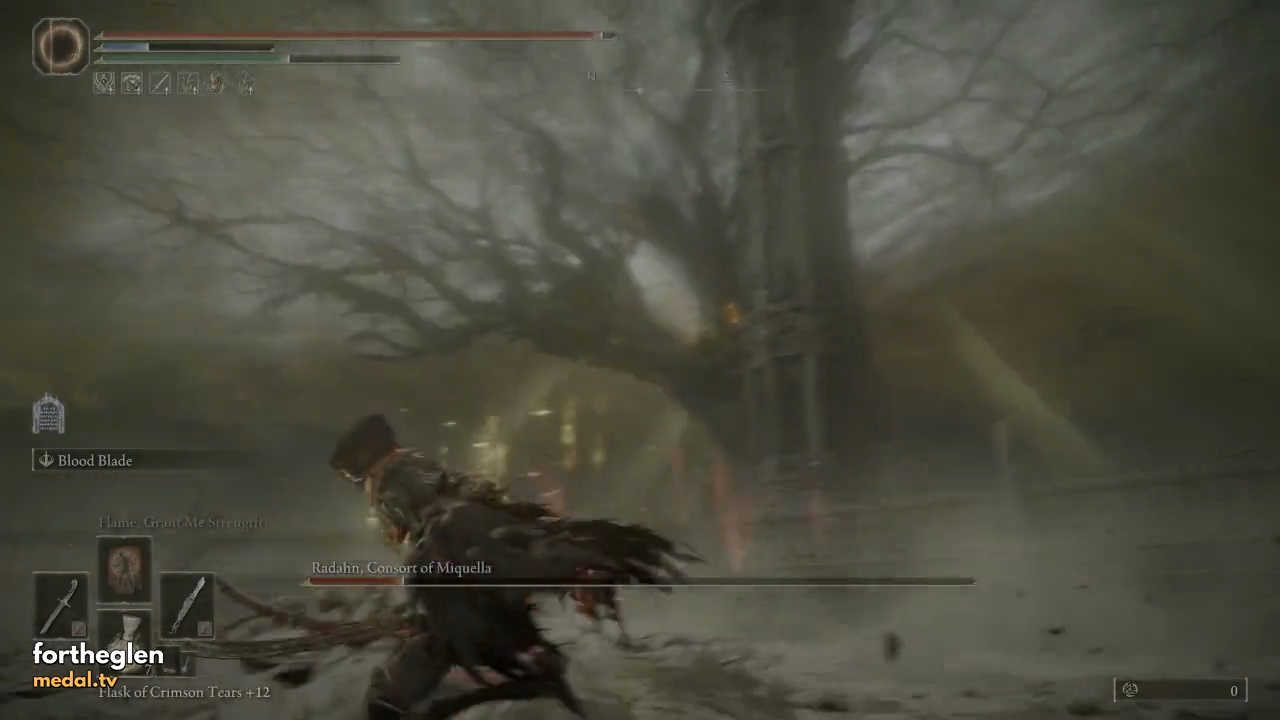

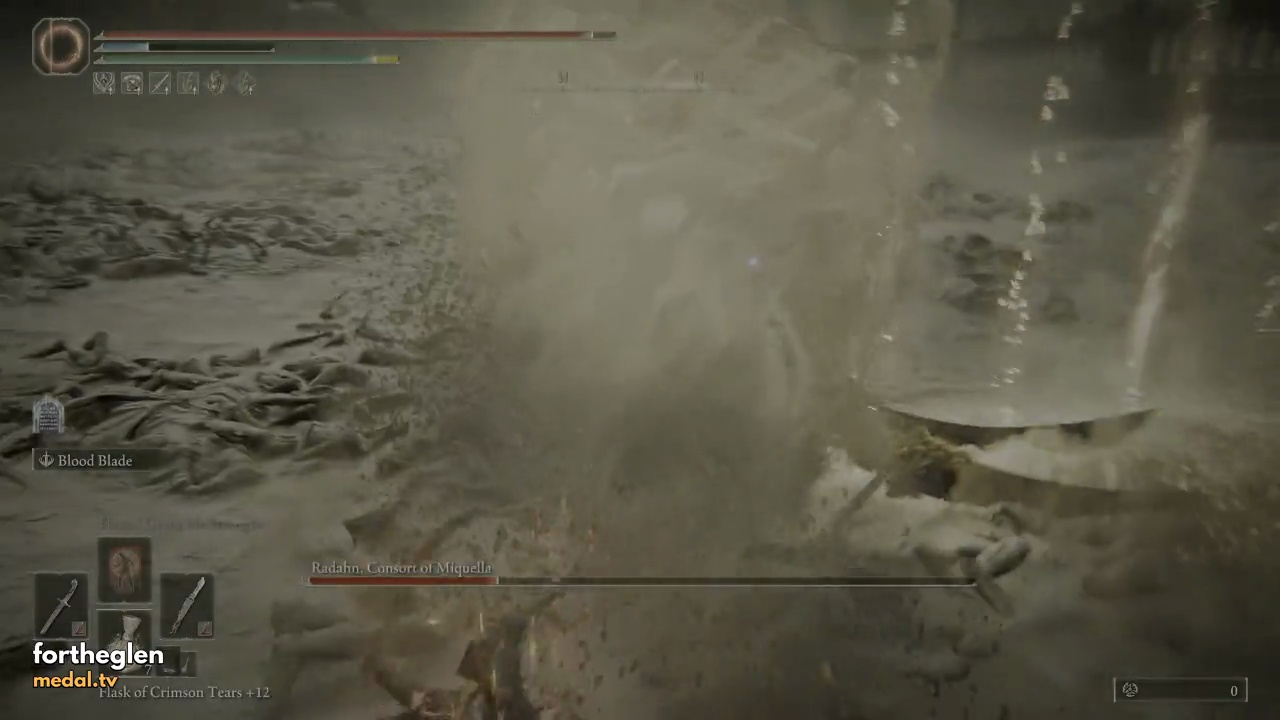

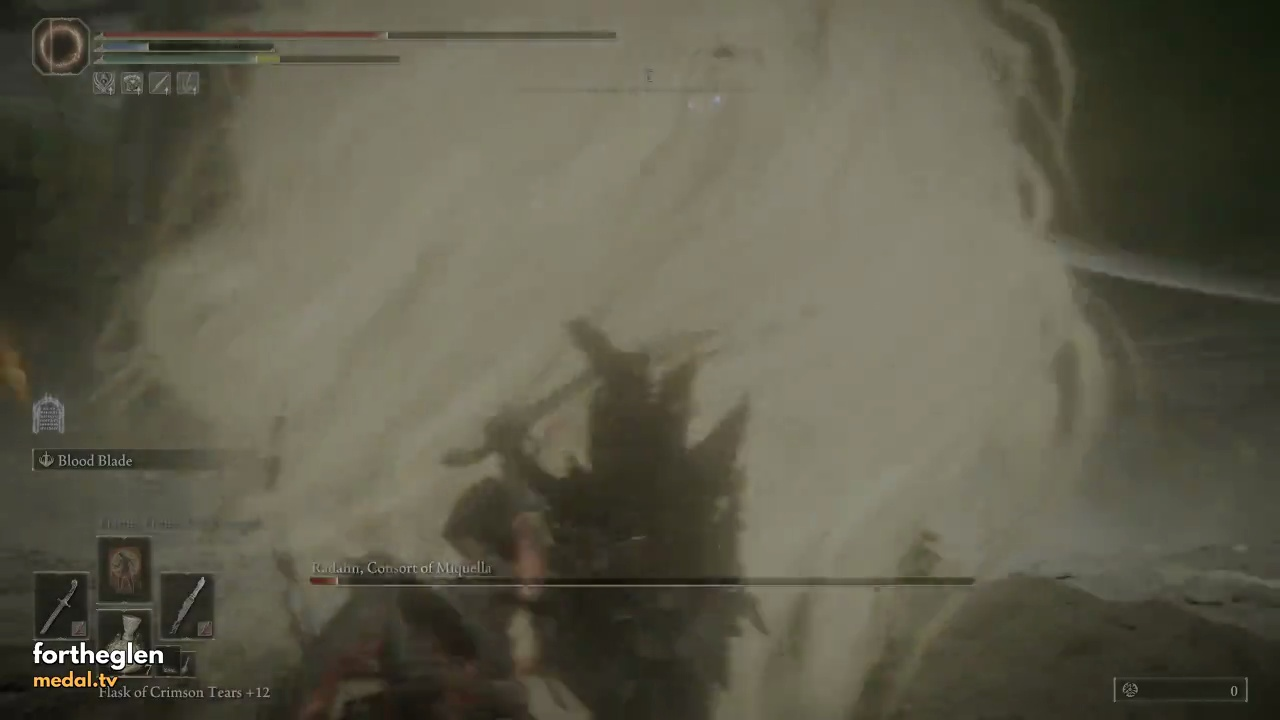

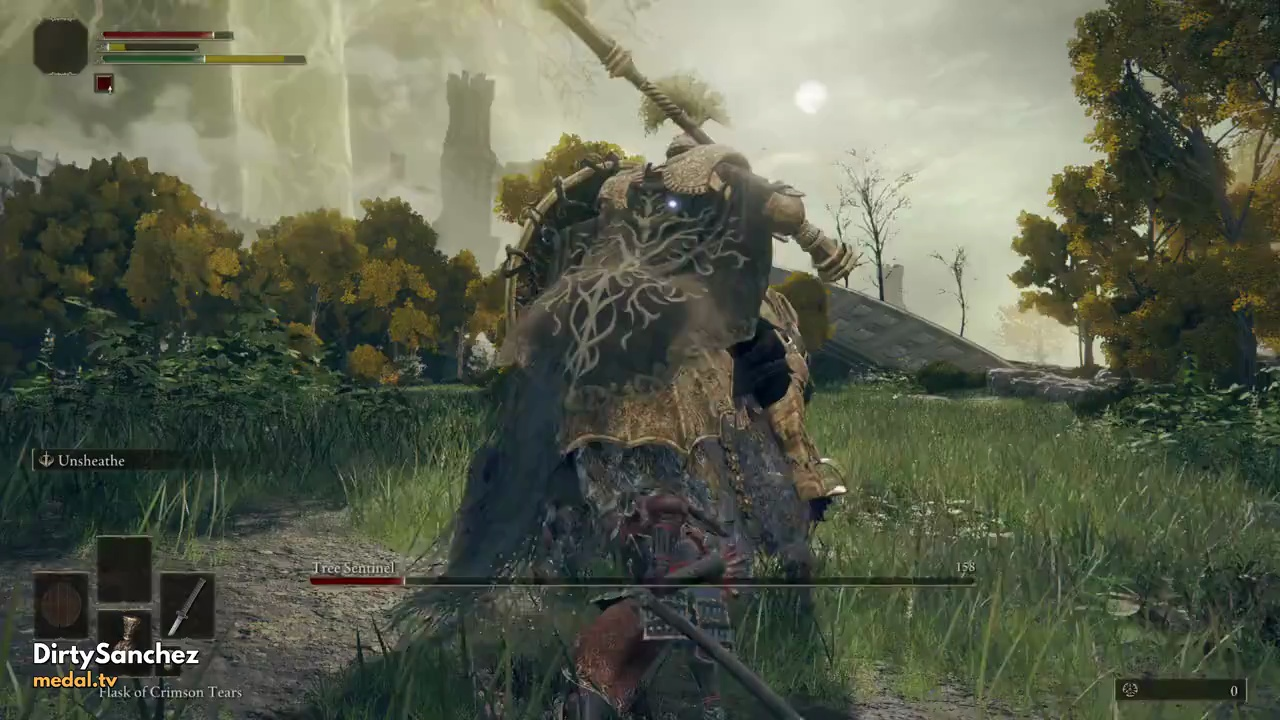




Cluster size: 10


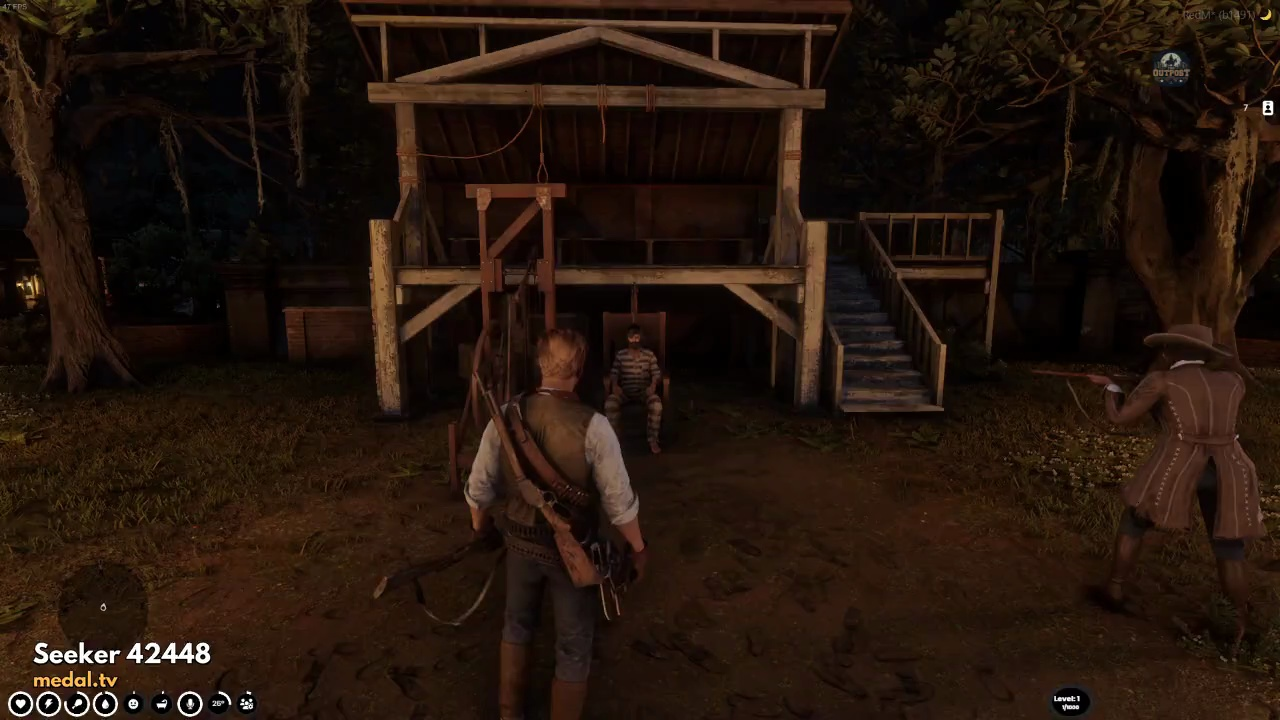

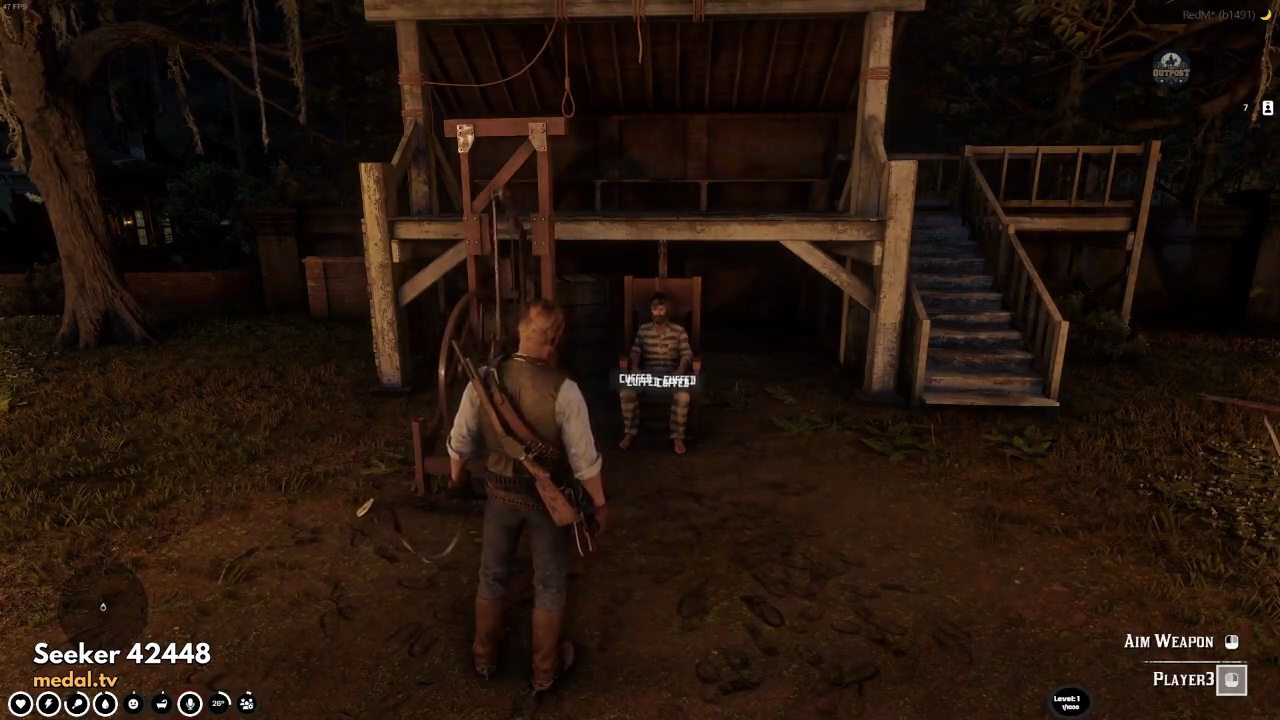

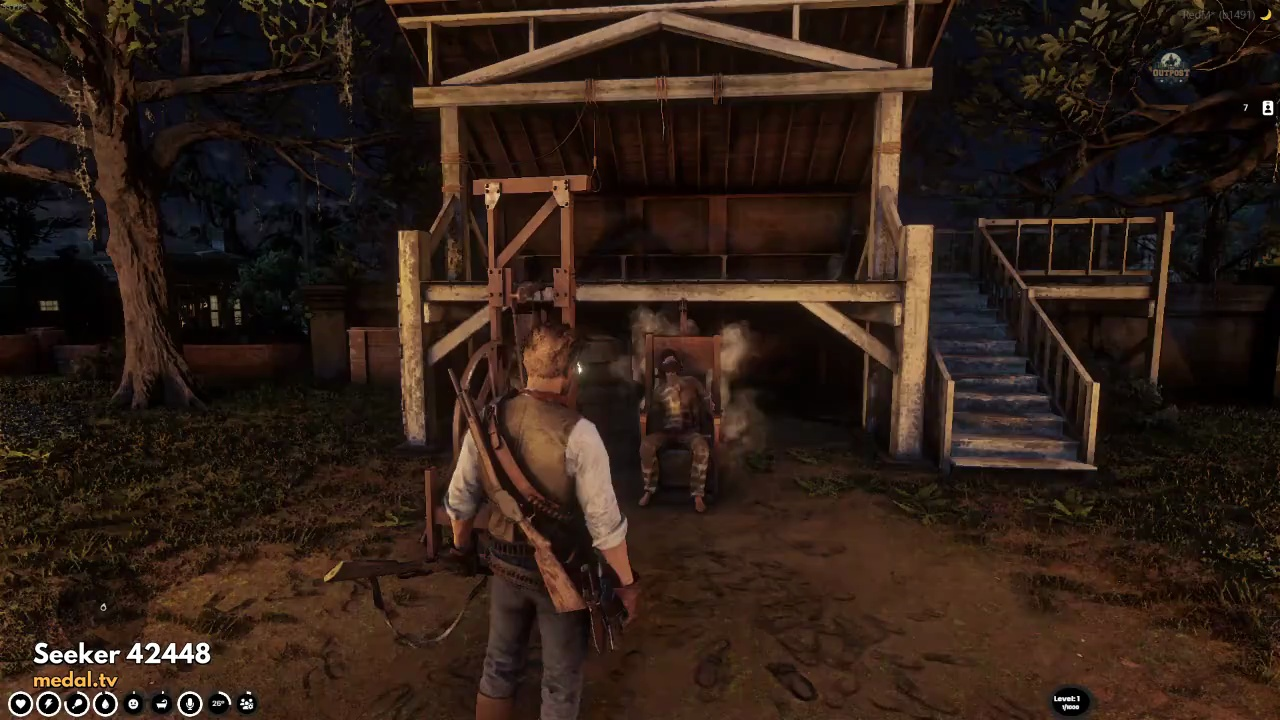

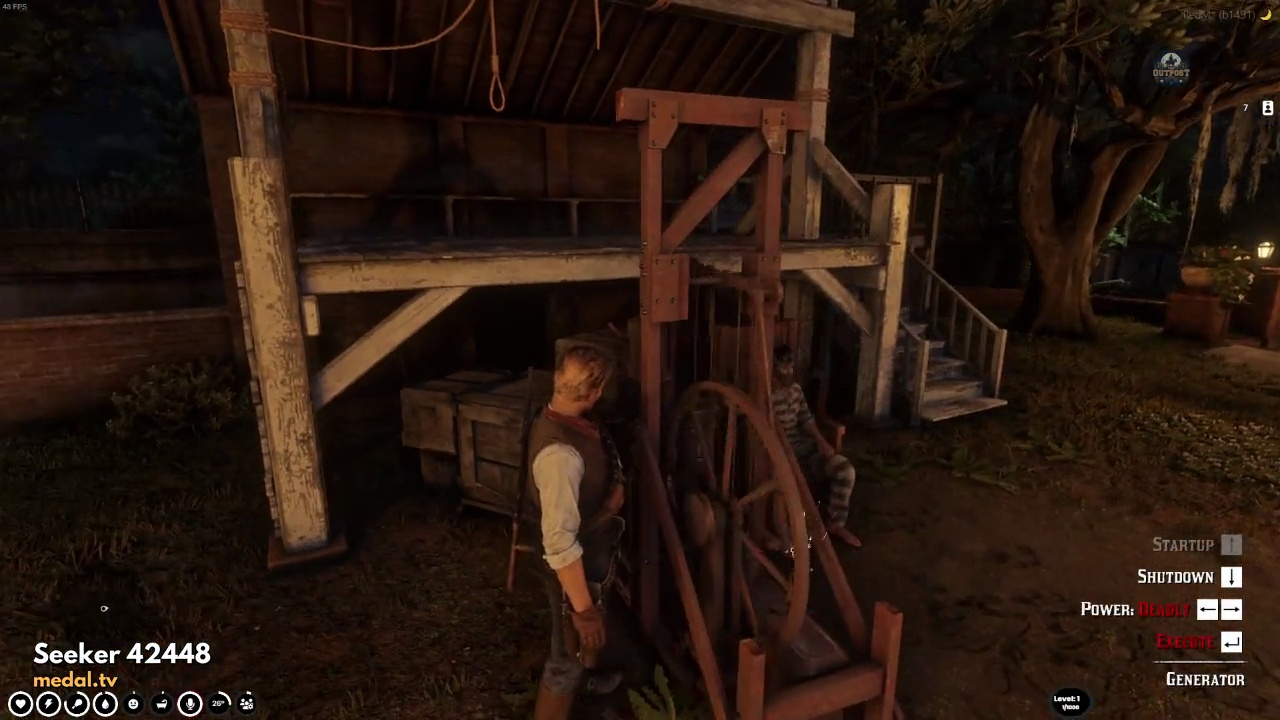

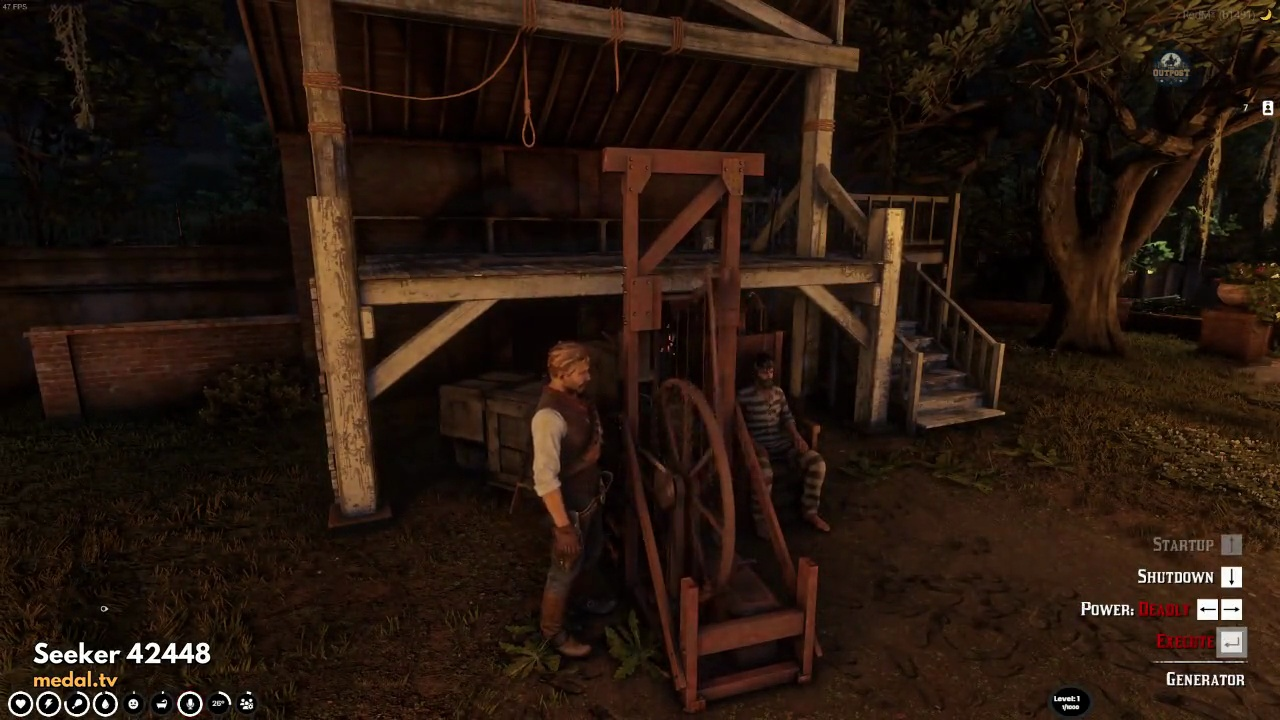

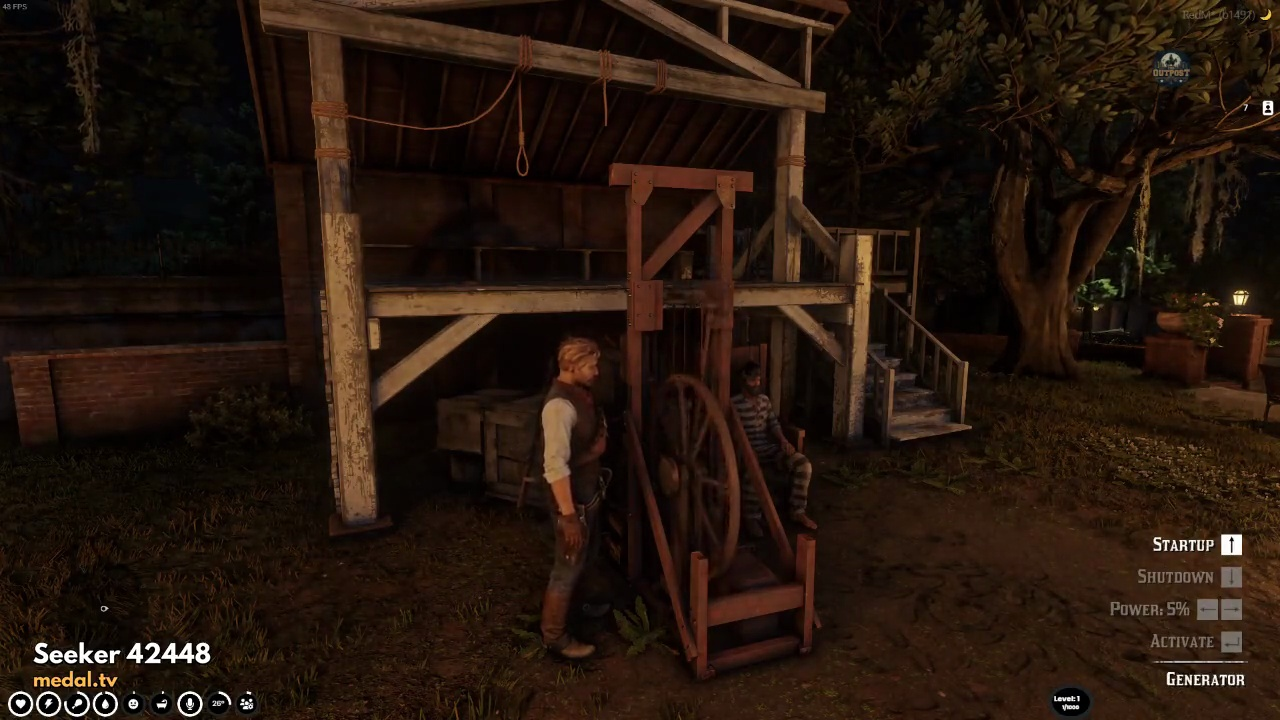

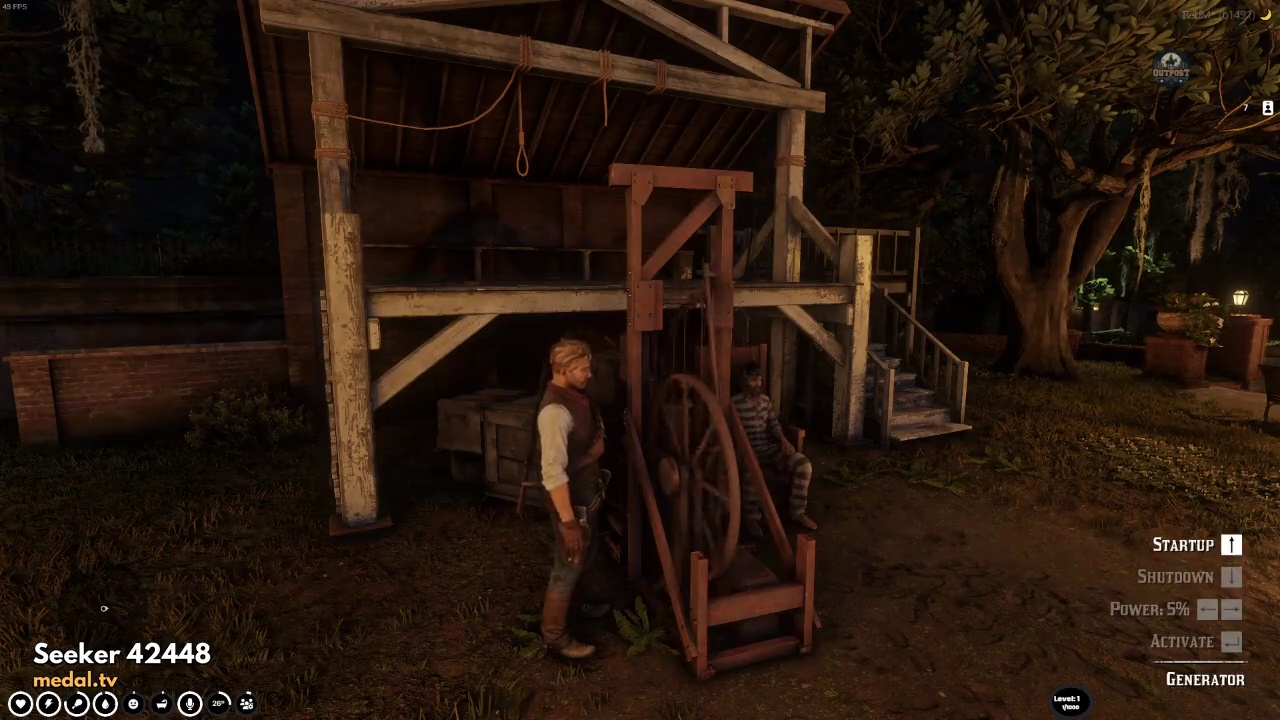

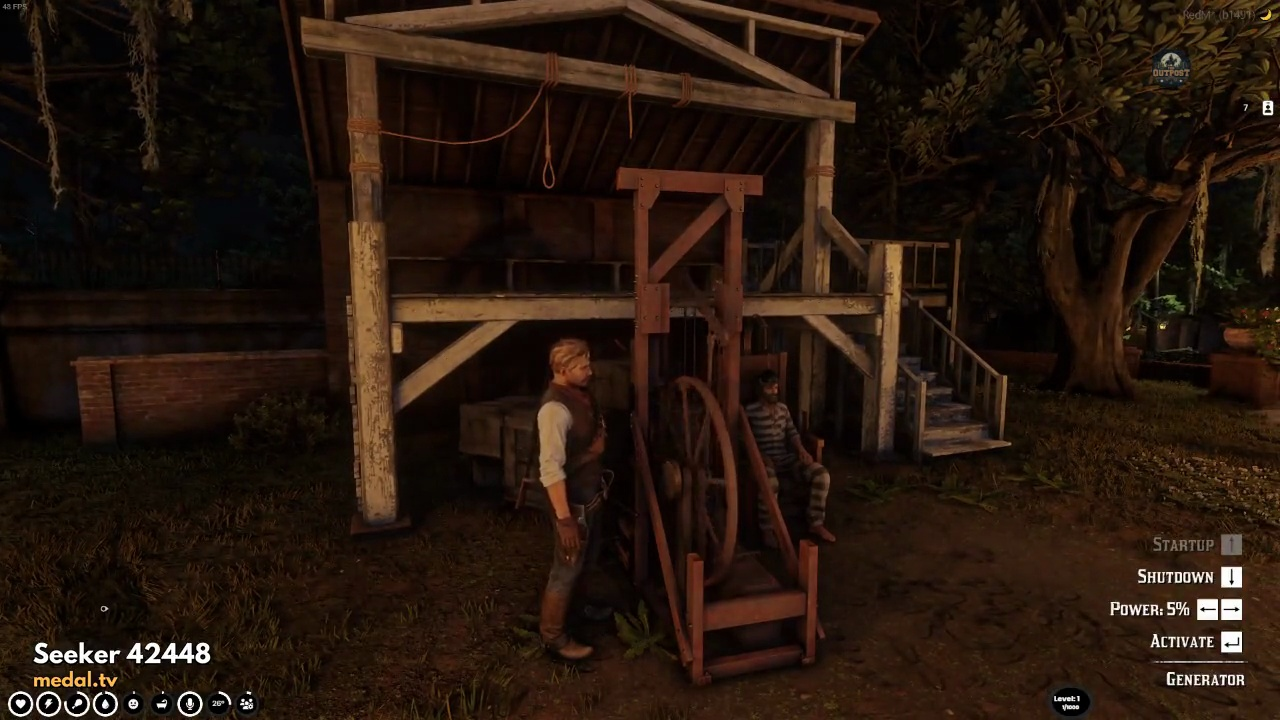

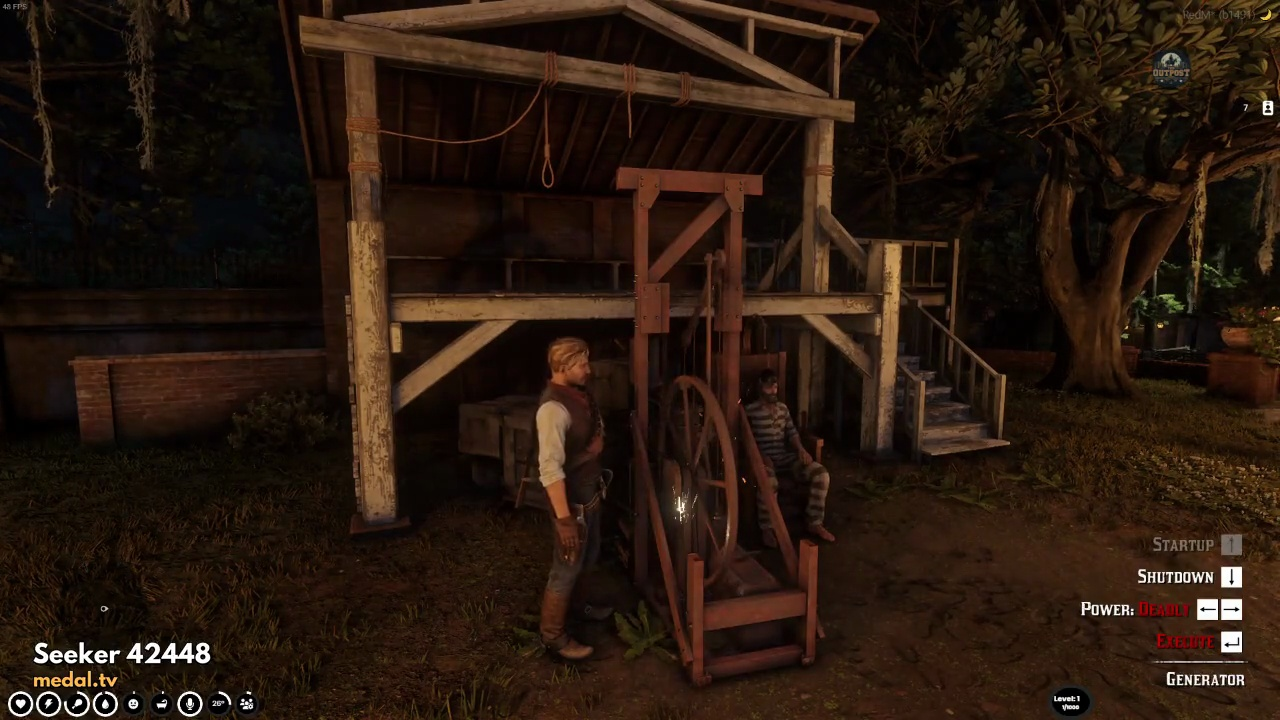

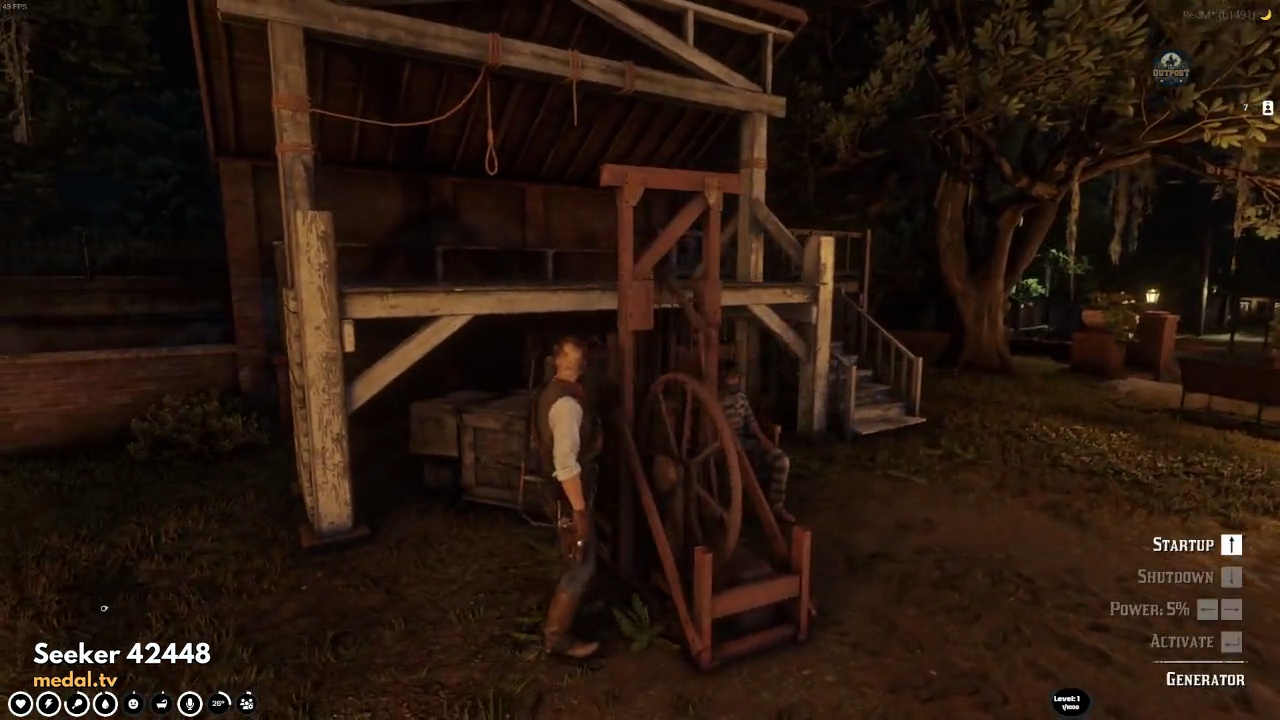




Cluster size: 6


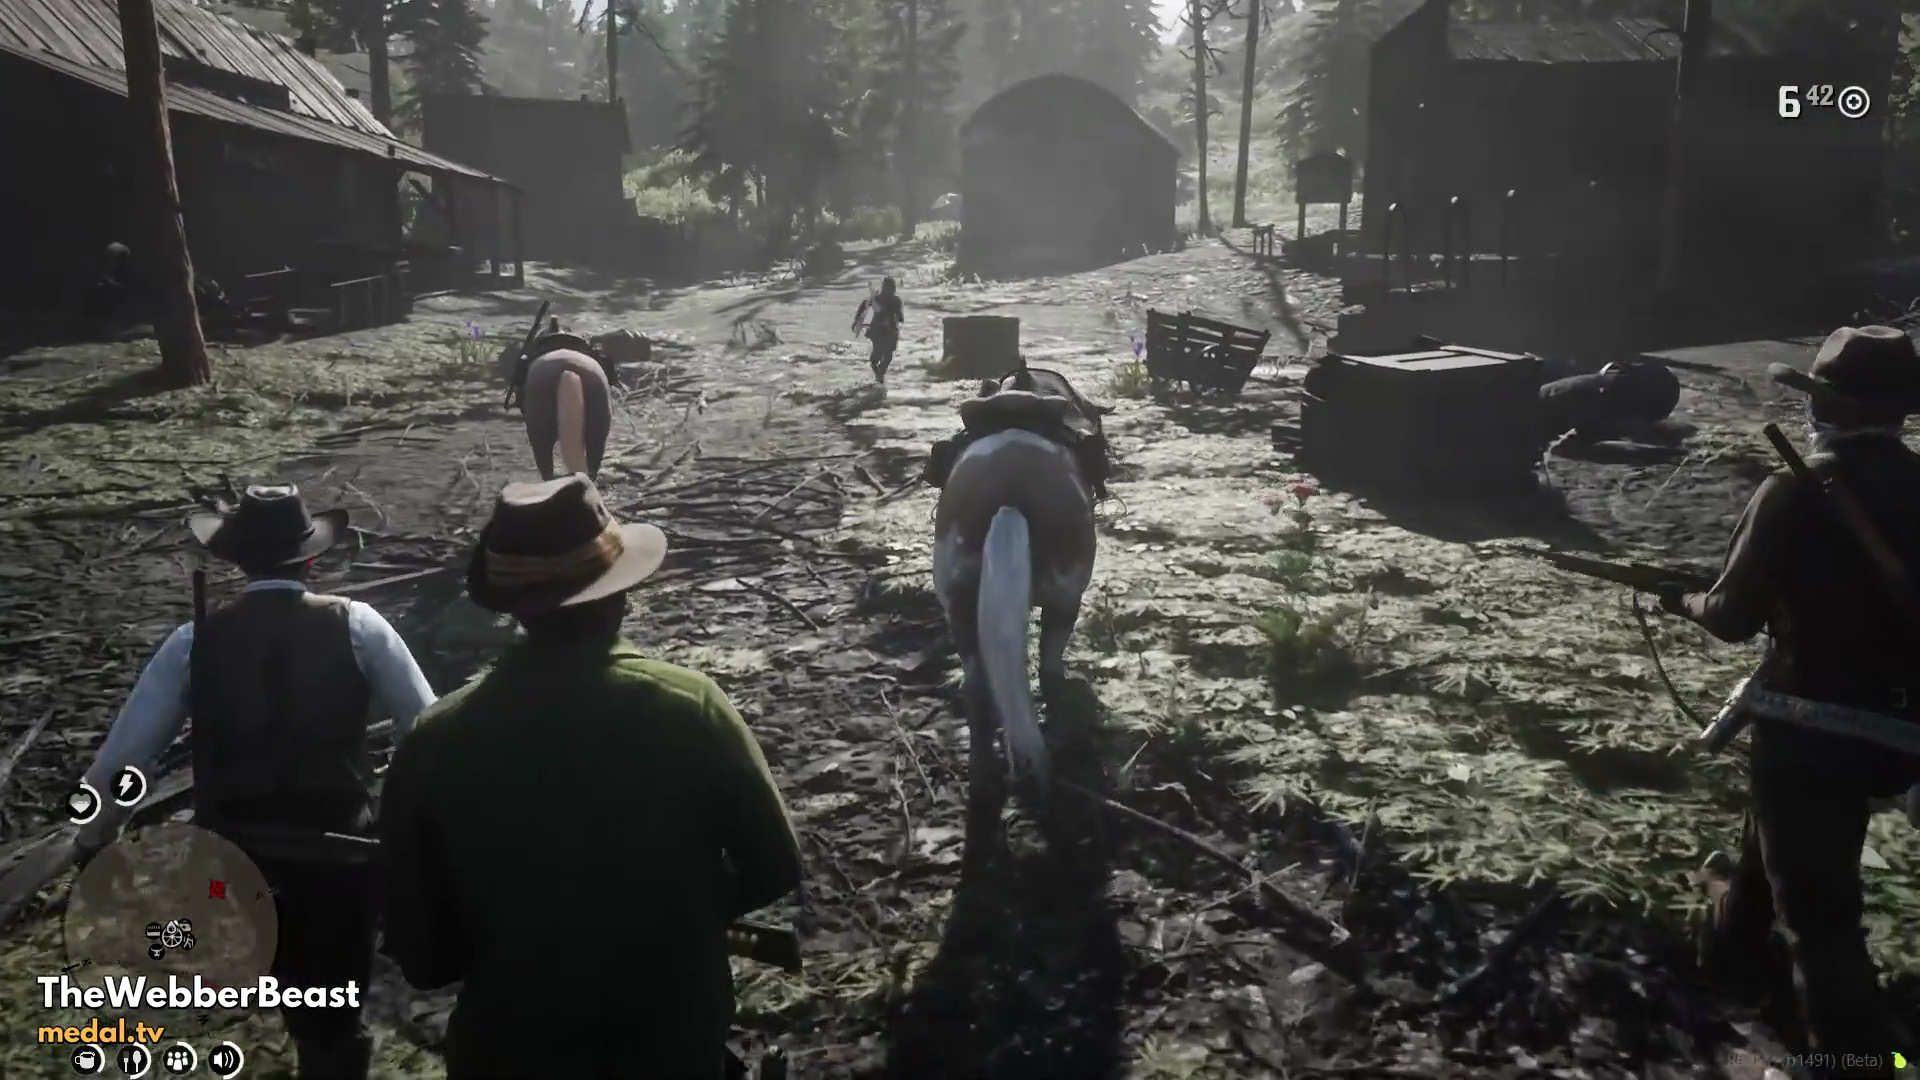

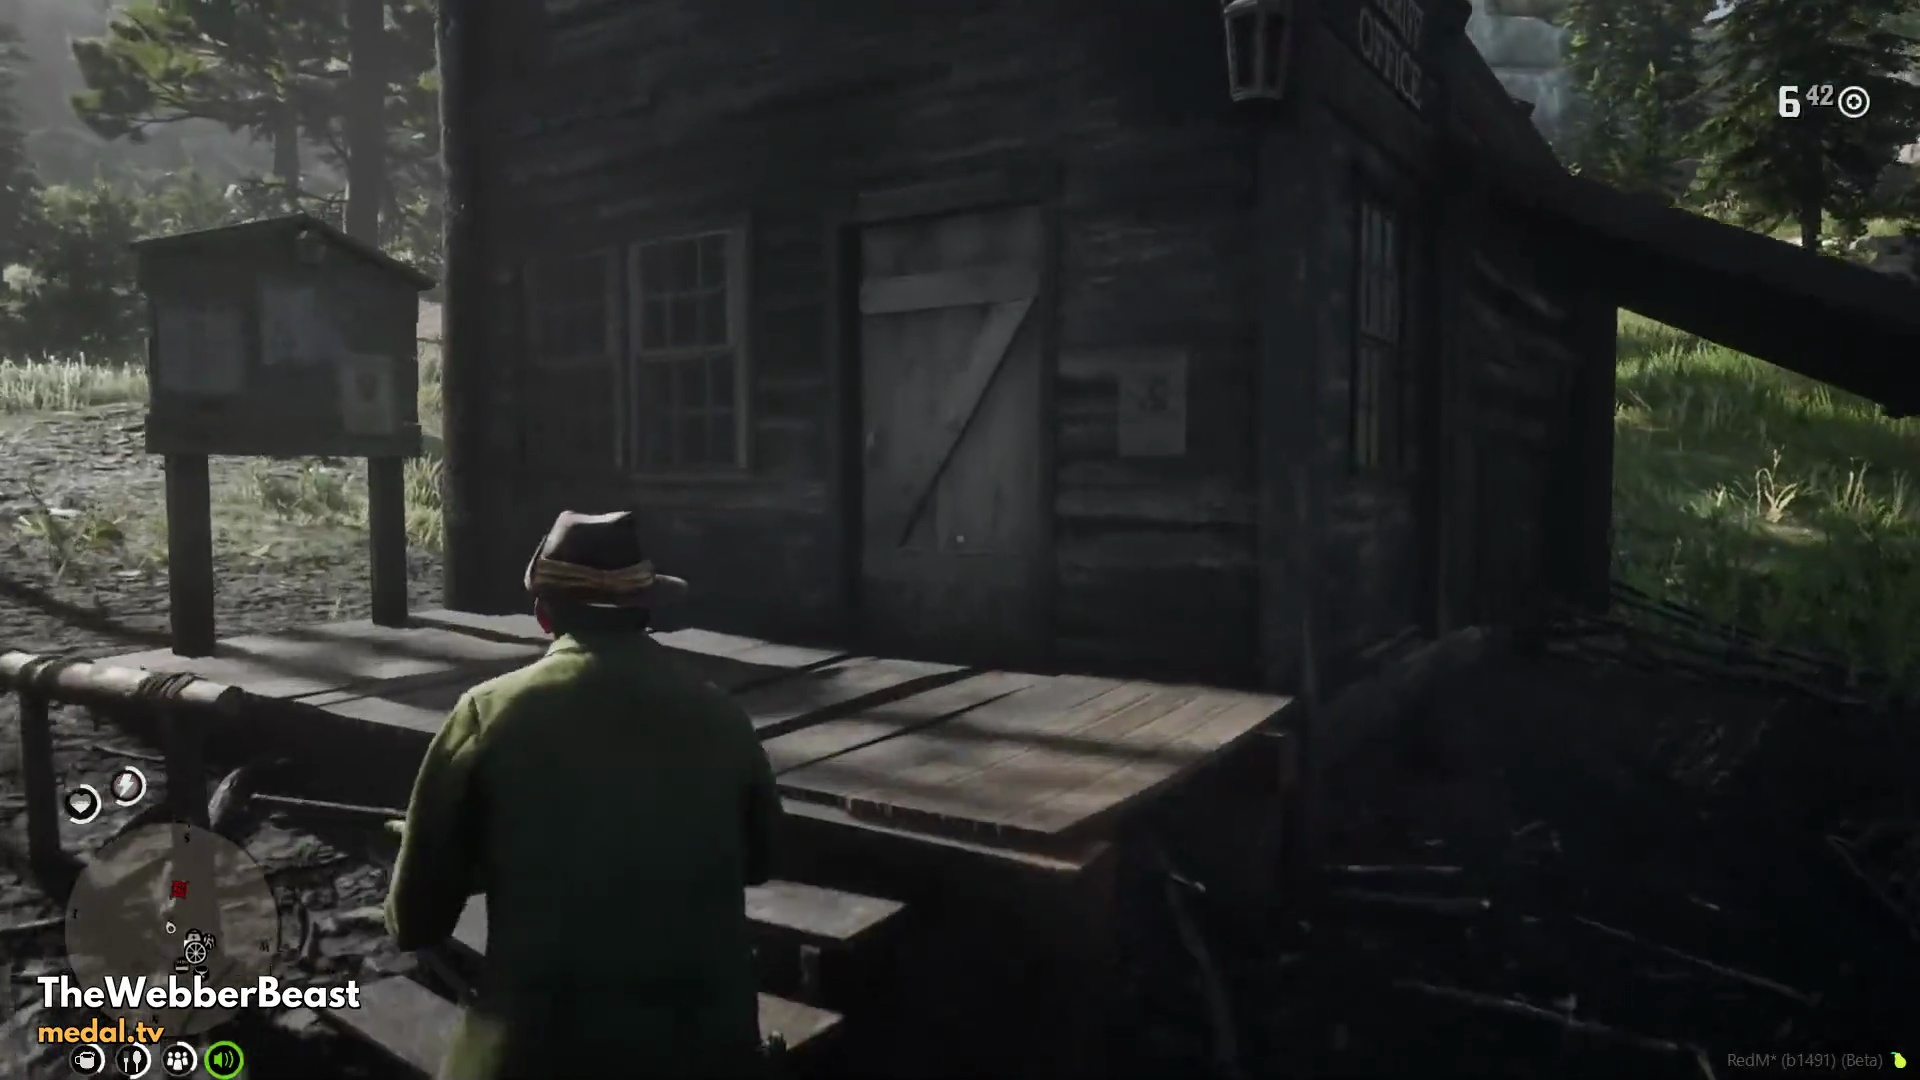

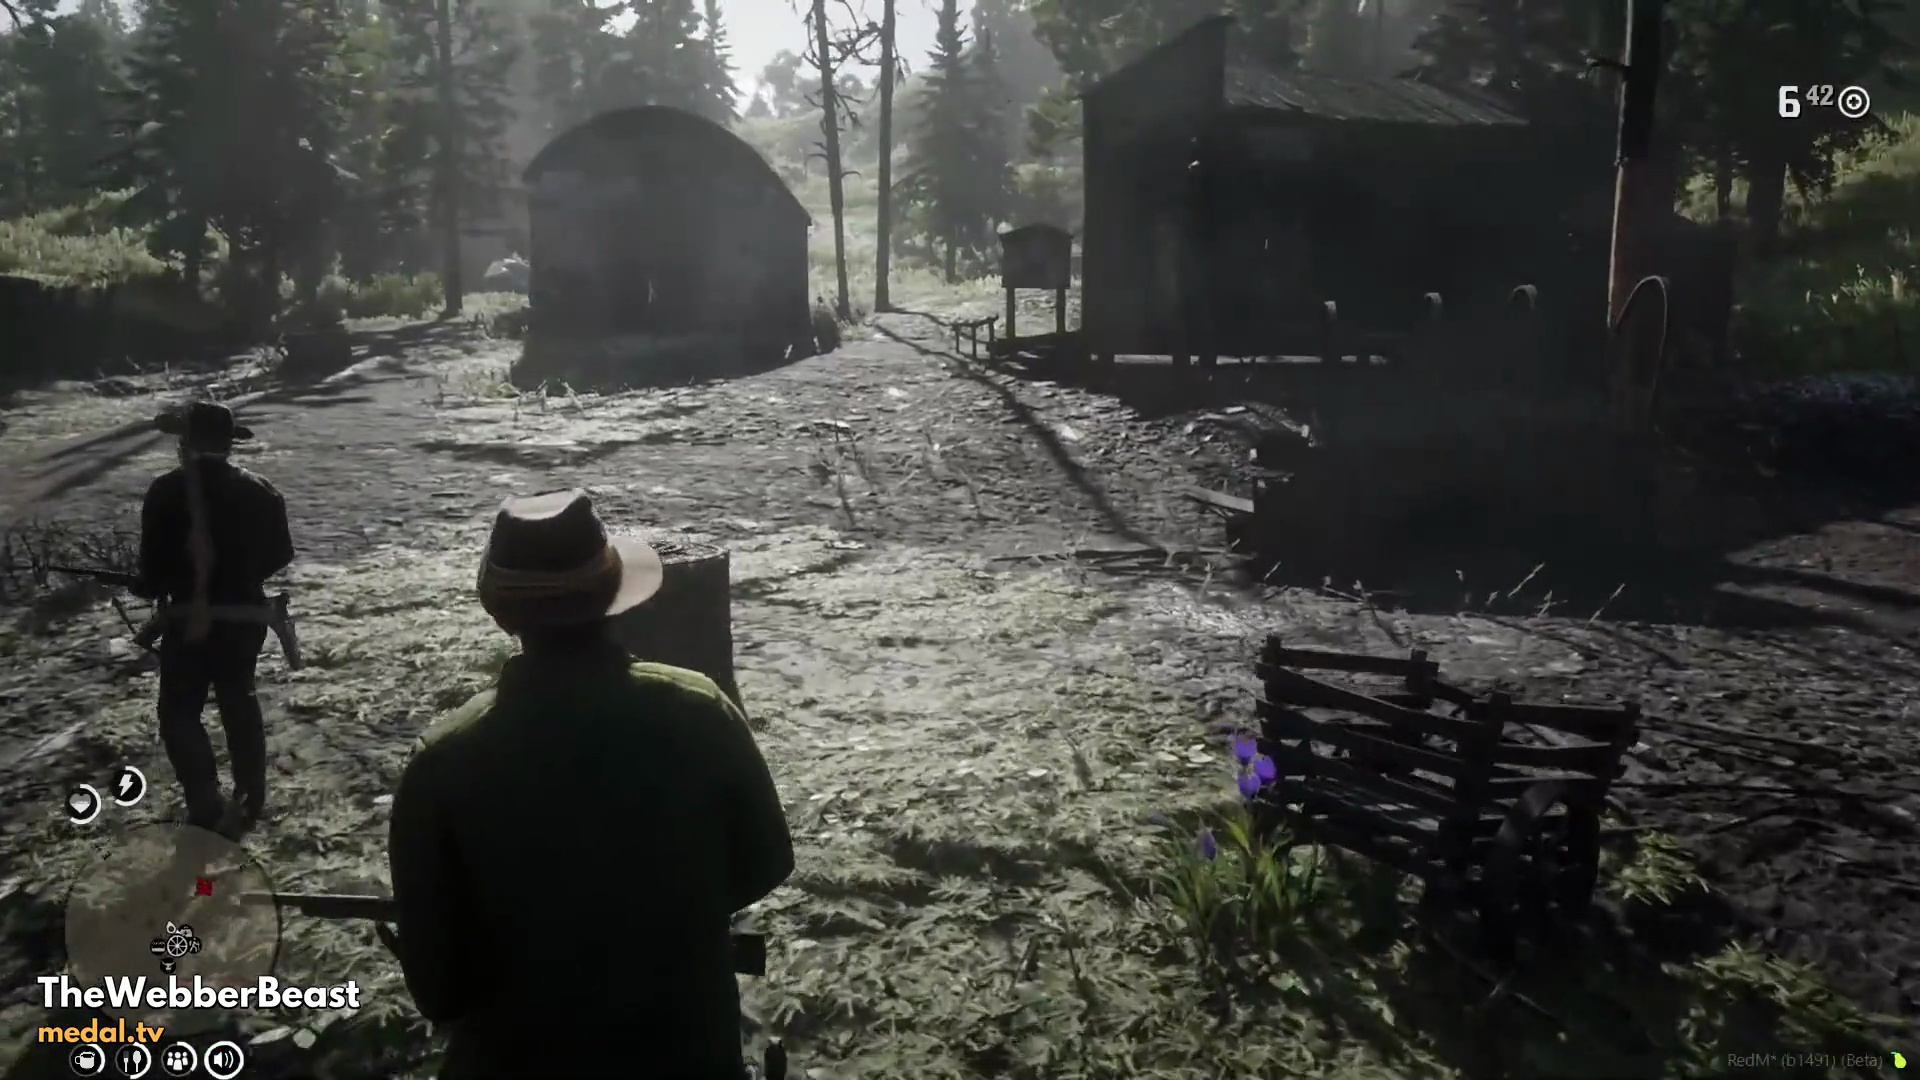

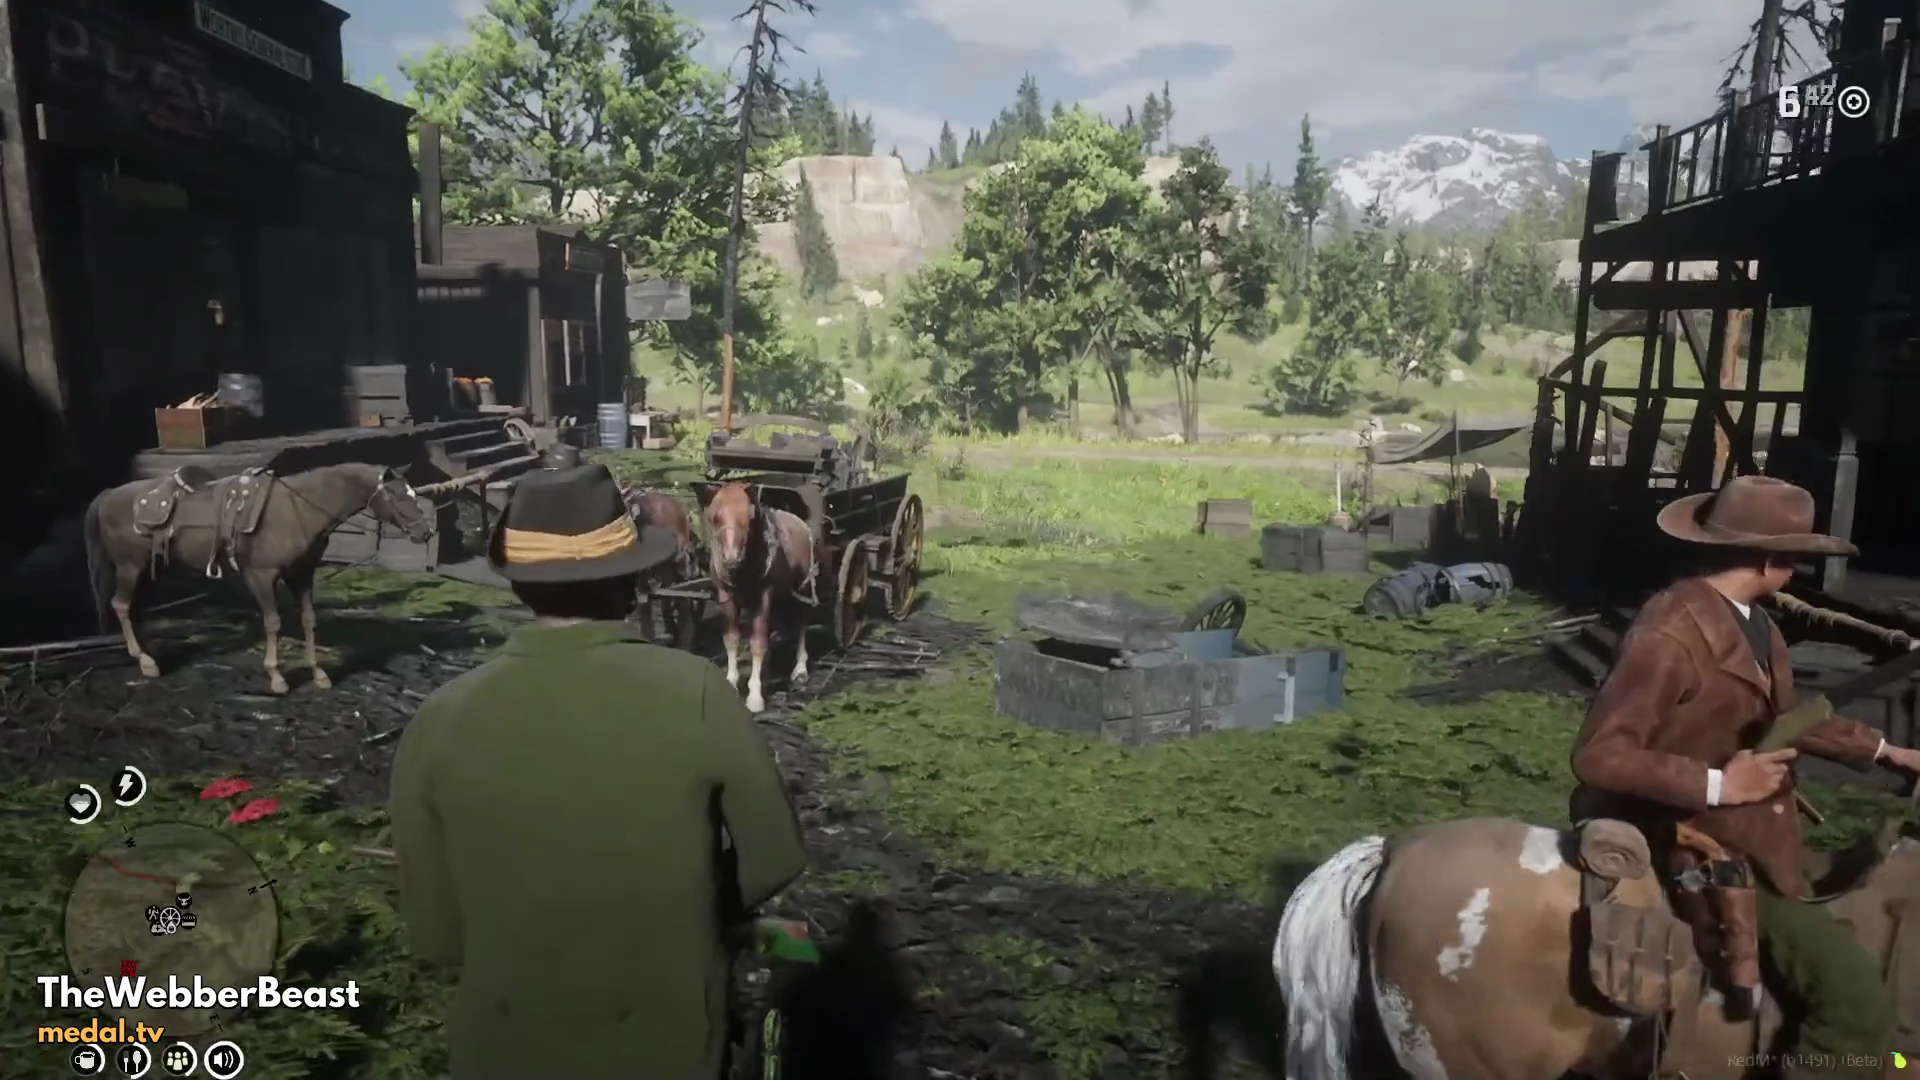

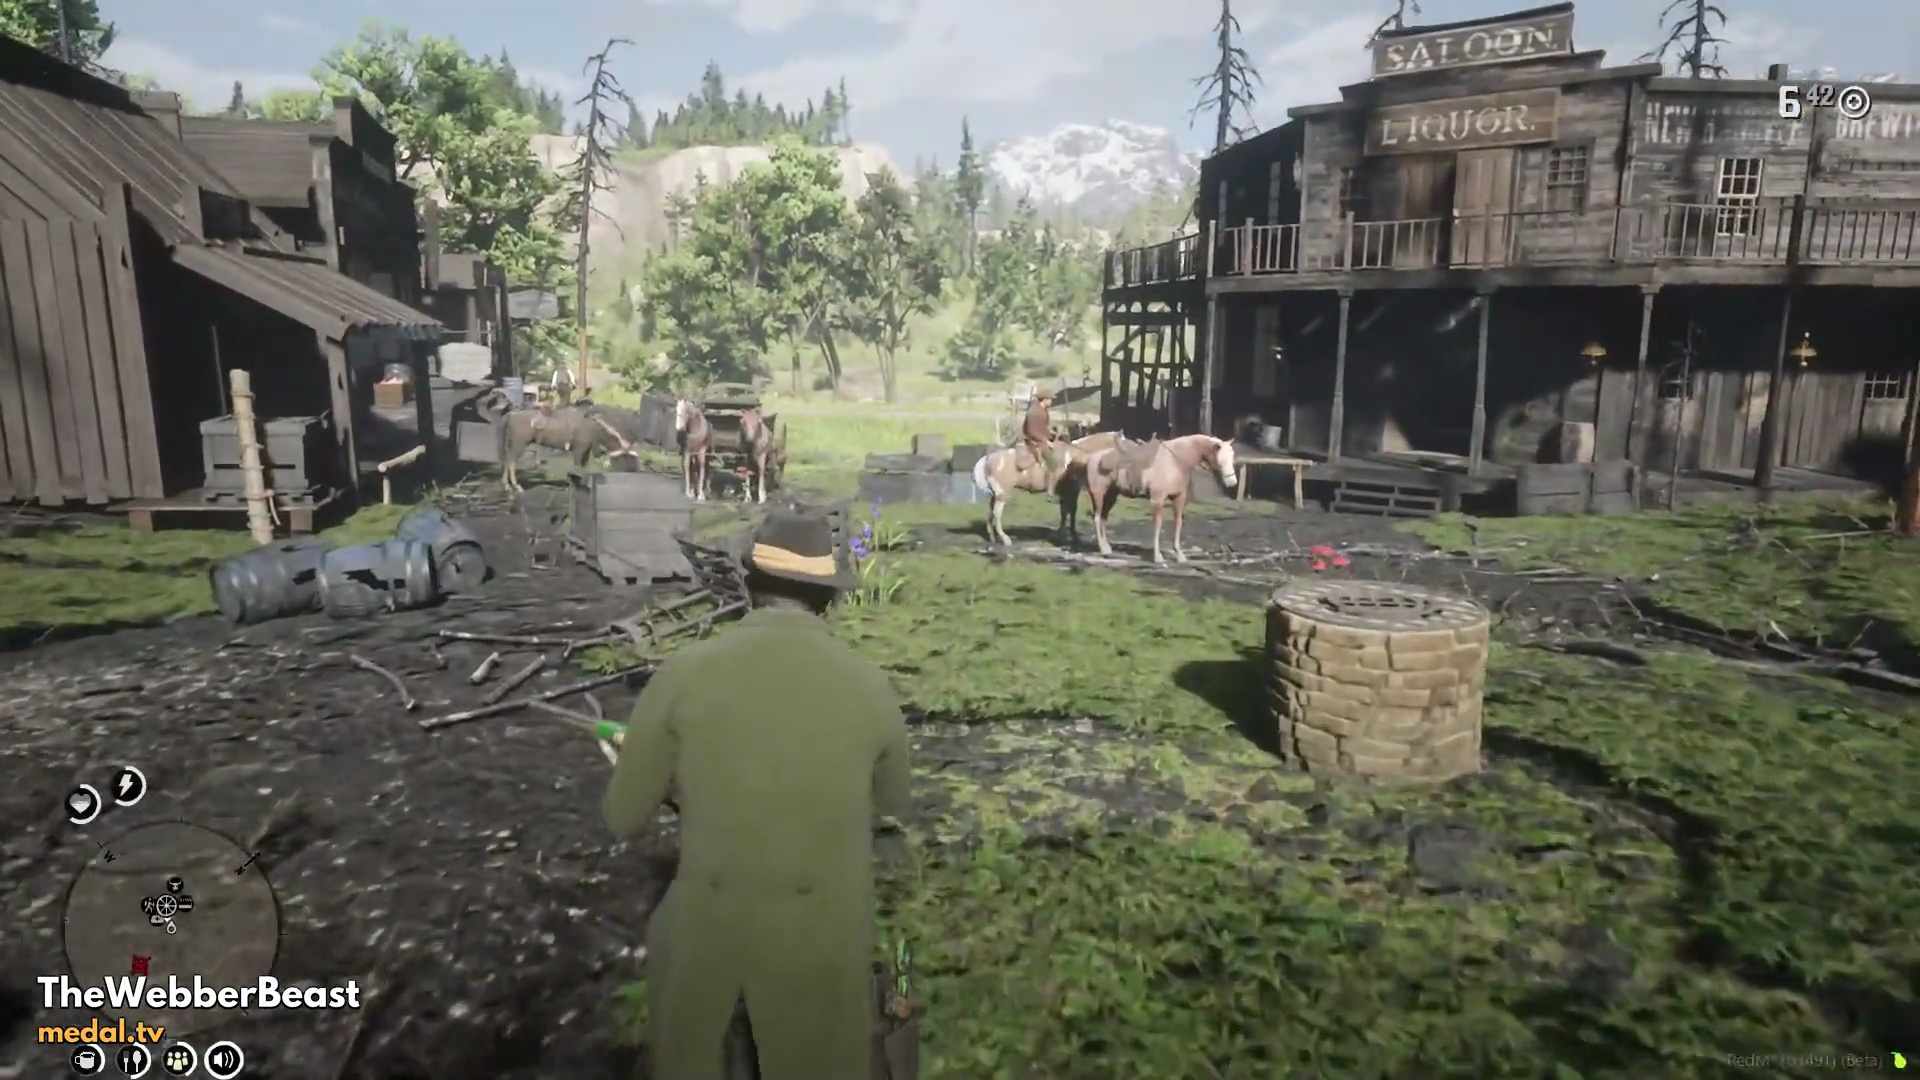

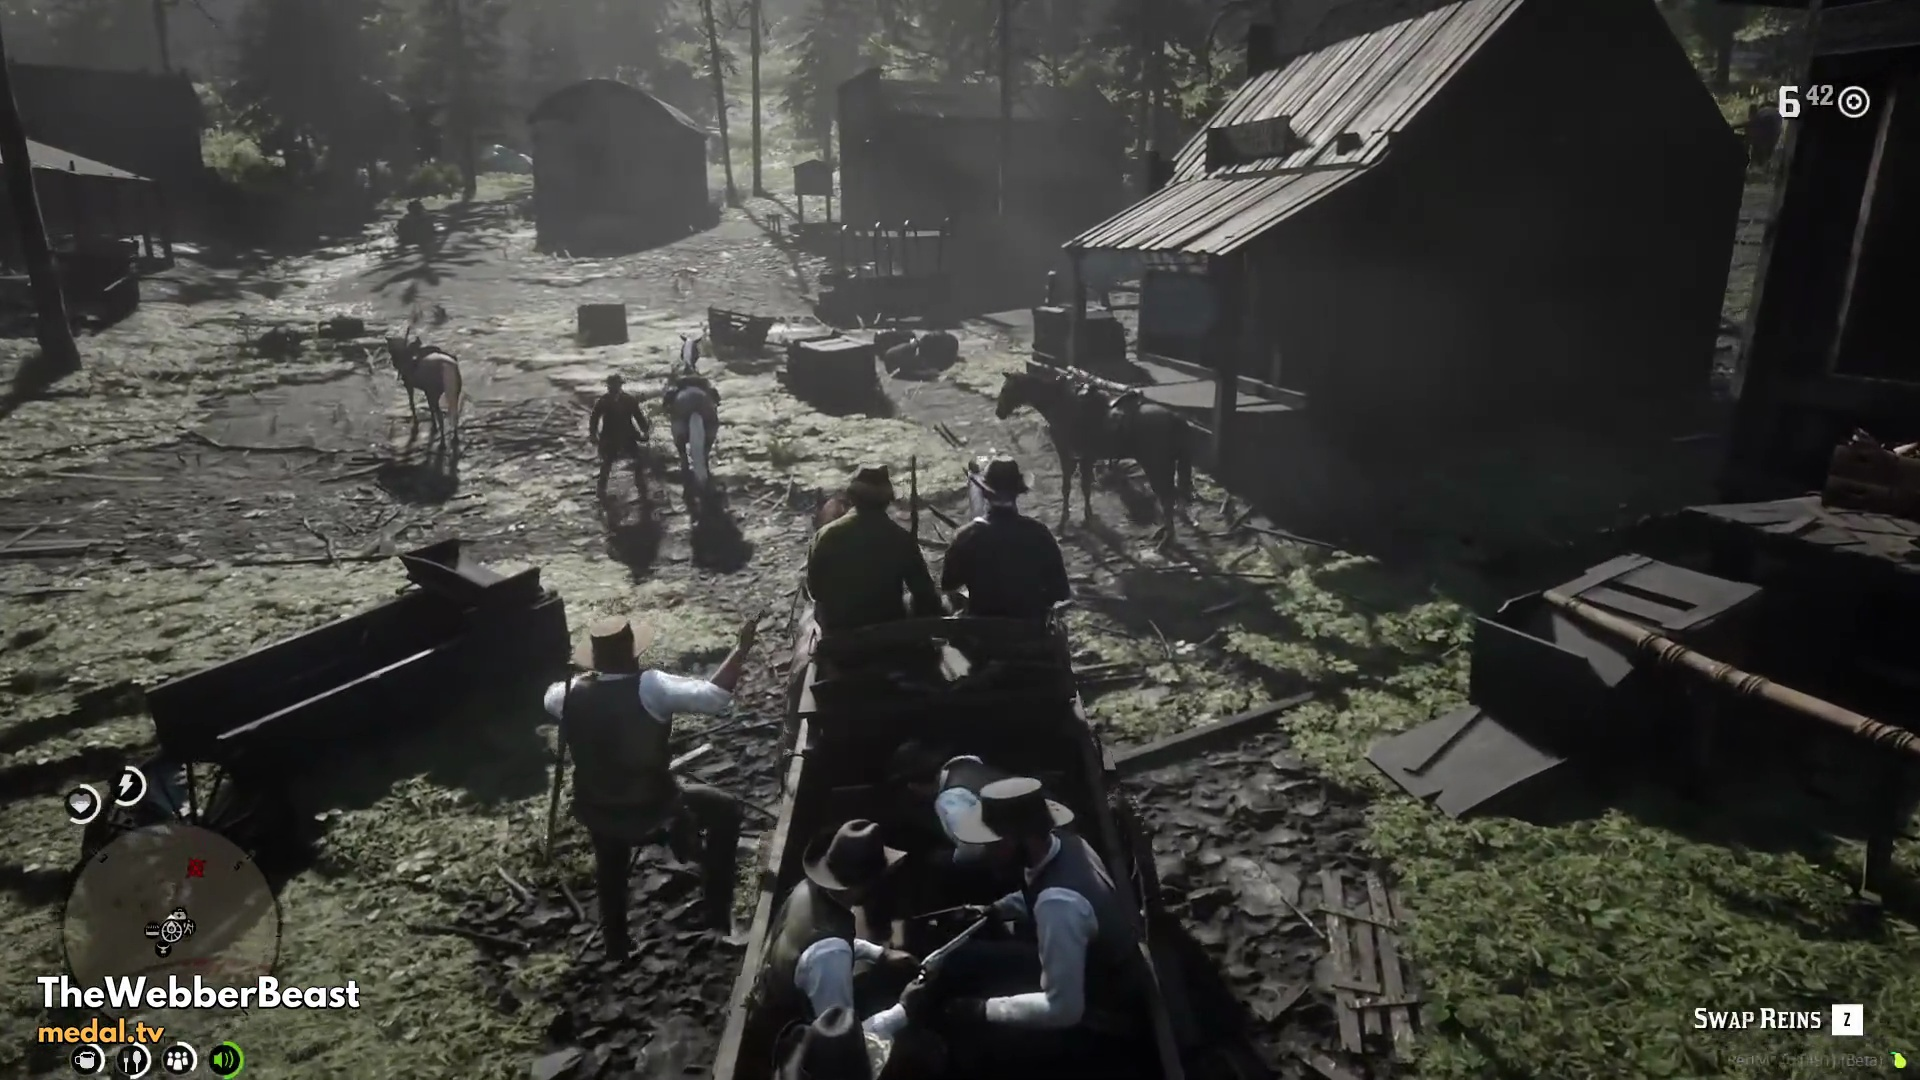

In [70]:
# Now we output the first 10 (largest) clusters
for cluster in clusters:
    print("\n\nCluster size:", len(cluster))
    
    #Output 3 images
    for idx in cluster:
        display(IPImage(all_imgs_paths[idx], width=200))
        print("")